In [1]:
import torch, torchvision
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import numpy as np
from torch.nn.functional import interpolate
from torch.optim import Adam

#Пробная загрузка датасета с Kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/tomato-detection

 98% 177M/180M [00:02<00:00, 100MB/s] 
100% 180M/180M [00:02<00:00, 92.4MB/s]


In [ ]:
!unzip "/content/tomato-detection.zip"

Archive:  /content/tomato-detection.zip
  inflating: annotations/tomato0.xml  
  inflating: annotations/tomato1.xml  
  inflating: annotations/tomato10.xml  
  inflating: annotations/tomato100.xml  
  inflating: annotations/tomato101.xml  
  inflating: annotations/tomato102.xml  
  inflating: annotations/tomato103.xml  
  inflating: annotations/tomato104.xml  
  inflating: annotations/tomato105.xml  
  inflating: annotations/tomato106.xml  
  inflating: annotations/tomato107.xml  
  inflating: annotations/tomato108.xml  
  inflating: annotations/tomato109.xml  
  inflating: annotations/tomato11.xml  
  inflating: annotations/tomato110.xml  
  inflating: annotations/tomato111.xml  
  inflating: annotations/tomato112.xml  
  inflating: annotations/tomato113.xml  
  inflating: annotations/tomato114.xml  
  inflating: annotations/tomato115.xml  
  inflating: annotations/tomato116.xml  
  inflating: annotations/tomato117.xml  
  inflating: annotations/tomato118.xml  
  inflating: annotation

# Импорт данных

In [5]:
!wget https://lodmedia.hb.bizmrg.com/case_files/969235/train_dataset_%D0%9C%D0%B8%D0%BD%D0%BF%D1%80%D0%B8%D1%80%D0%BE%D0%B4%D1%8B.zip

--2023-05-20 13:42:31--  https://lodmedia.hb.bizmrg.com/case_files/969235/train_dataset_%D0%9C%D0%B8%D0%BD%D0%BF%D1%80%D0%B8%D1%80%D0%BE%D0%B4%D1%8B.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1760622760 (1.6G) [application/zip]
Saving to: ‘train_dataset_Минприроды.zip’

train_dataset_Минпр 100%[===================>]   1.64G  21.8MB/s    in 81s     

2023-05-20 13:43:54 (20.7 MB/s) - ‘train_dataset_Минприроды.zip’ saved [1760622760/1760622760]



In [6]:
!unzip /content/train_dataset_Минприроды.zip

Archive:  /content/train_dataset_Минприроды.zip
 extracting: разметка_кликун.zip  
 extracting: разметка_малый.zip  
 extracting: разметка_шипун.zip  
  inflating: Определение_лебедей_по_внешнему_виду.docx  
  inflating: Пояснение к оценке.docx  


In [7]:
!unzip /content/разметка_кликун.zip
!unzip /content/разметка_малый.zip
!unzip /content/разметка_шипун.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: разметка_шипун/images/img_1943.jpg  
 extracting: разметка_шипун/images/img_1944.jpg  
 extracting: разметка_шипун/images/img_1945.jpg  
 extracting: разметка_шипун/images/img_1946.jpg  
 extracting: разметка_шипун/images/img_1947.jpg  
 extracting: разметка_шипун/images/img_1948.jpg  
 extracting: разметка_шипун/images/img_1949.jpg  
 extracting: разметка_шипун/images/img_195.jpg  
 extracting: разметка_шипун/images/img_1950.jpg  
 extracting: разметка_шипун/images/img_1951.jpg  
 extracting: разметка_шипун/images/img_1952.jpg  
 extracting: разметка_шипун/images/img_1953.jpg  
 extracting: разметка_шипун/images/img_1954.jpg  
 extracting: разметка_шипун/images/img_1955.jpg  
 extracting: разметка_шипун/images/img_1956.jpg  
 extracting: разметка_шипун/images/img_1957.jpg  
 extracting: разметка_шипун/images/img_1958.jpg  
 extracting: разметка_шипун/images/img_1959.jpg  
 extracting: разметка_шипун/image

In [8]:
os.mkdir("/content/data/")

In [9]:
!mv /content/klikun /content/data
!mv /content/разметка_малый /content/data
!mv /content/разметка_шипун /content/data

In [ ]:
!mv /content/data2/images /content/data2/разметка_малый
!mv /content/data2/masks /content/data2/разметка_малый
!mv /content/data2/разметка_малый /content/data
!mv /content/data2/разметка_шипун /content/data

In [10]:
os.rename("/content/data/klikun", "/content/data/Кlikun")
os.rename("/content/data/разметка_малый", "/content/data/Maliy")
os.rename("/content/data/разметка_шипун", "/content/data/Shipun")

# Предобработка данных

In [ ]:
class SwanDataset(Dataset):
  SPLIT_RANDOM_SEED = 42
  TEST_SIZE = 0.25

  def __init__(self, root, train=True, transform=None, input_shape = None):
    super().__init__()
    self.root = root
    self.train = train
    self.transform = transform
    self.images = []
    self.masks = []
    self.labels = []
    self.classes = ["Кlikun", "Maliy", "Shipun"]
    self.input_shape = input_shape
    for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
      images = [os.path.join(self.root, class_name, "images", name) for name in os.listdir(os.path.join(self.root, class_name, "images")) if not os.path.isdir(os.path.join(self.root, class_name, "images", name))]
      masks = [os.path.join(self.root, class_name, "masks", name.replace("jpg", "png")) for name in os.listdir(os.path.join(self.root, class_name, "images")) if not os.path.isdir(os.path.join(self.root, class_name, "images", name))]
      train_images, test_images, train_masks, test_masks = train_test_split(images, masks, random_state=self.SPLIT_RANDOM_SEED,
                                                  test_size=self.TEST_SIZE)
      if self.train:
          self.images += train_images
          self.masks += train_masks
          self.labels += [i] * len(train_images)
      else:
          self.images += test_images
          self.masks += test_masks
          self.labels += [i] * len(test_images)
  def __len__(self):
    return len(self.images)
  def __getitem__(self, item):
    image = Image.open(self.images[item]).convert('RGB')
    if self.input_shape != None:
      image = image.resize(self.input_shape)
    if self.transform != None:
      image = self.transform(image)
    target = self.labels[item]
    return image, target

In [ ]:
ROOT = "/content/data/"

In [ ]:
transform = None
size = None
train_dataset = SwanDataset(ROOT, True, transform, size)
test_dataset = SwanDataset(ROOT, False, transform, size)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
len(train_dataset)

6777

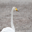

In [ ]:
obj = train_dataset[2]
obj[0].show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
len(train_loader)

212

In [ ]:
def show(imgs):
    to_pil = T.ToPILImage()
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

# Нейронная сеть

In [ ]:
from torchvision.models import inception_v3

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

num_epochs = 5
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

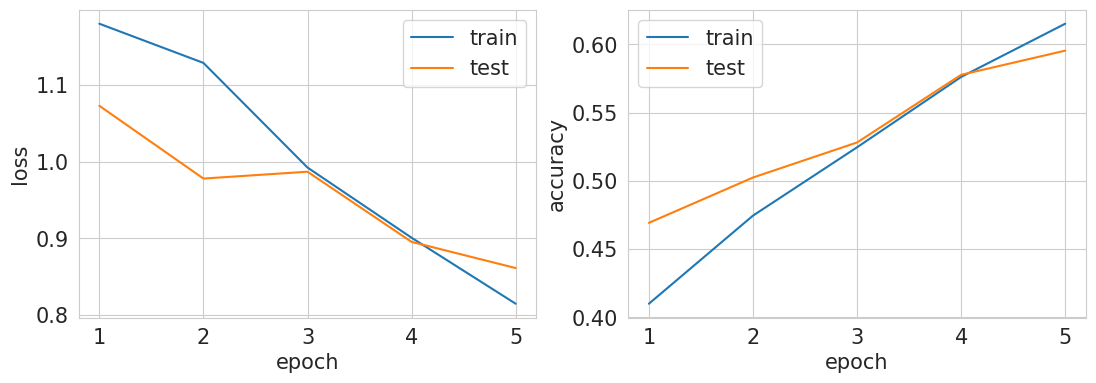

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
T.ToTensor()(Image.open(train_dataset.masks[0])).unique().sort().values[1:]

tensor([0.4980, 0.9961])

In [ ]:
train_dataset.masks[0]

'/content/data/Кликун/masks/3070040415.png'

In [ ]:
def create_boxes(mask, label):
  target = {}
  unic_values = mask.unique().sort().values[1:]
  target["boxes"] = torch.tensor([[mask.size()[2], mask.size()[1], 0, 0] for i in unic_values])
  target["labels"] = []
  [target["labels"].append(label) for i in unic_values]
  target["labels"] = torch.tensor(target["labels"])
  for y, val1 in enumerate(mask[0]):
    for x, val2 in enumerate(val1):
      for ind, i in enumerate(unic_values):
        if val2 != i:
          continue
        if y < target["boxes"][ind][1]:
          target["boxes"][ind][1] = y
        if y > target["boxes"][ind][3]:
          target["boxes"][ind][3] = y
        if x < target["boxes"][ind][0]:
          target["boxes"][ind][0] = x
        if x > target["boxes"][ind][2]:
          target["boxes"][ind][2] = x
  return target

In [ ]:
boxes = create_boxes(train_dataset.masks[0], train_dataset[0][1])

In [ ]:
boxes

{'annotation': {'source': {'database': 'The swan database',
   'annotation': 'Swans',
   'image': 'Swan'},
  'size': {'width': 1200, 'height': 1600, 'depth': 1600},
  'folder': 'SwanDataset',
  'filename': '3978996511.png',
  'segmented': '0',
  'object': [{'name': 0,
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': 0,
    'bndbox': {'xmin': '279', 'ymin': '554', 'xmax': '901', 'ymax': '819'},
    'difficult': '0'},
   {'name': 0,
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': 0,
    'bndbox': {'xmin': '136', 'ymin': '382', 'xmax': '763', 'ymax': '1137'},
    'difficult': '0'},
   {'name': 0,
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': 0,
    'bndbox': {'xmin': '436', 'ymin': '609', 'xmax': '1131', 'ymax': '1250'},
    'difficult': '0'}]}}

In [ ]:
[idx2target[label.item()] for label in boxes['labels']]

['Кликун', 'Кликун']

In [ ]:
Image.open(train_dataset.images[0]).size

(500, 429)

In [ ]:
Image.open(train_dataset.masks[0]).size

(500, 429)

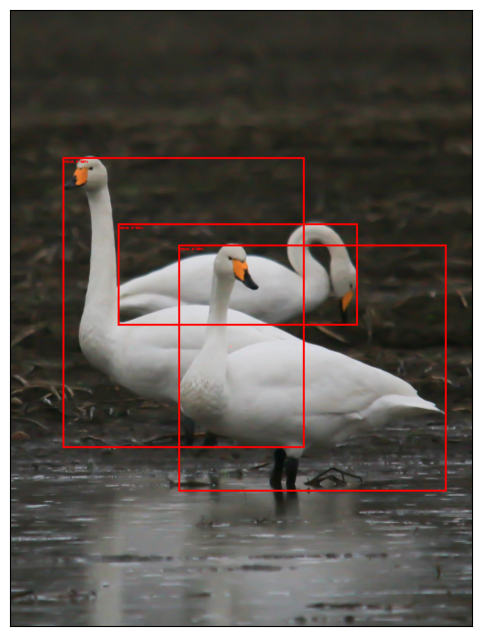

In [ ]:
index = 0
draw_boxes_single_image(
    T.PILToTensor()(train_dataset[index][0]),
    boxes['boxes'],
    [idx2target[label.item()] for label in boxes['labels']]
)

# Детекция

In [11]:
class SwanDetectionDataset(Dataset):
  SPLIT_RANDOM_SEED = 42
  TEST_SIZE = 0.25

  def __init__(self, root, train=True, transform=None, input_shape=None):
    super().__init__()
    self.root = root
    self.train = train
    self.transform = transform
    self.images = []
    self.targets = []
    self.boxes = []
    self.original_sizes = []
    self.input_shape = input_shape
    self.classes = ["Кlikun", "Maliy", "Shipun"]
    for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
      images = [os.path.join(self.root, class_name, "images", name) for name in os.listdir(os.path.join(self.root, class_name, "images")) if not os.path.isdir(os.path.join(self.root, class_name, "images", name))]
      masks = [os.path.join(self.root, class_name, "masks", name.replace("jpg", "png")) for name in os.listdir(os.path.join(self.root, class_name, "images")) if not os.path.isdir(os.path.join(self.root, class_name, "images", name))]
      dicts = [create_boxes(mask, i, class_name) for mask in masks]
      targets = [i[1] for i in dicts]
      boxes = [i[1] for i in dicts]
      train_images, test_images, train_targets, test_targets, train_boxes, test_boxes = train_test_split(images, targets, boxes, random_state=self.SPLIT_RANDOM_SEED,
                                                  test_size=self.TEST_SIZE)
      if self.train:
          self.images += train_images
          self.targets += train_targets
          self.boxes += train_boxes
      else:
          self.images += test_images
          self.targets += test_targets
          self.boxes += test_boxes
  def __len__(self):
    return len(self.images)
  def __getitem__(self, item):
    image = Image.open(self.images[item]).convert('RGB')
    if self.input_shape != None:
      image = image.resize(self.input_shape)
    if self.transform != None:
      image = self.transform(image)
    target = self.targets[item]
    return image, target

In [33]:
def create_boxes(mask, label, class_name):
  result = {"annotation":{"source":{}, "size":{}}}
  result["annotation"]["folder"] = "SwanDataset"
  result["annotation"]["filename"] = mask.split("/")[-1]
  result["annotation"]["source"]["database"] = "The swan database"
  result["annotation"]["source"]["annotation"] = "Swans"
  result["annotation"]["source"]["image"] = "Swan"
  pil = Image.open(mask)
  image = T.ToTensor()(pil)
  size = image.size()
  result["annotation"]["size"]["width"] = size[2]
  result["annotation"]["size"]["height"] = size[1]
  result["annotation"]["size"]["depth"] = size[1]
  result["annotation"]["segmented"] = "0"
  result["annotation"]["object"] = []
  np_mask = image[0].numpy()
  target = {}
  unic_values = (image.unique().sort().values[1:]).numpy()
  target["boxes"] = torch.tensor([[image.size()[2], image.size()[1], 0, 0] for i in unic_values])
  target["labels"] = []
  [target["labels"].append(label) for i in unic_values]
  target["labels"] = torch.tensor(target["labels"])
  for ind, i in enumerate(unic_values):
    indexes = np.where(np_mask == i)
    ymin = indexes[0].min()
    ymax = indexes[0].max()
    xmin = indexes[1].min()
    xmax = indexes[1].max()
    target["boxes"][ind][1] = ymin
    target["boxes"][ind][3] = ymax
    target["boxes"][ind][0] = xmin
    target["boxes"][ind][2] = xmax
  for ind, i in enumerate(target["boxes"]):
    obj = {"name":class_name, "pose":"Unspecified", "truncated":"0", "occluded":0}
    obj["bndbox"] = {"xmin":str(i[0].item()), "ymin":str(i[1].item()), "xmax":str(i[2].item()), "ymax":str(i[3].item())}
    obj["difficult"] = "0"
    result["annotation"]["object"].append(obj)
  return [result, target]

In [15]:
ROOT = "/content/data/"

In [16]:
transform = None
input_shape = None
train_detection_dataset = SwanDetectionDataset(ROOT, True, transform, input_shape)
test_detection_dataset = SwanDetectionDataset(ROOT, False, transform, input_shape)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
target2idx = {name: i for i, name in enumerate(train_detection_dataset.classes)}
idx2target = {i: name.encode(encoding='UTF-8',errors='strict') for i, name in enumerate(train_detection_dataset.classes)}

In [28]:
def show(imgs):
    to_pil = T.ToPILImage()
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

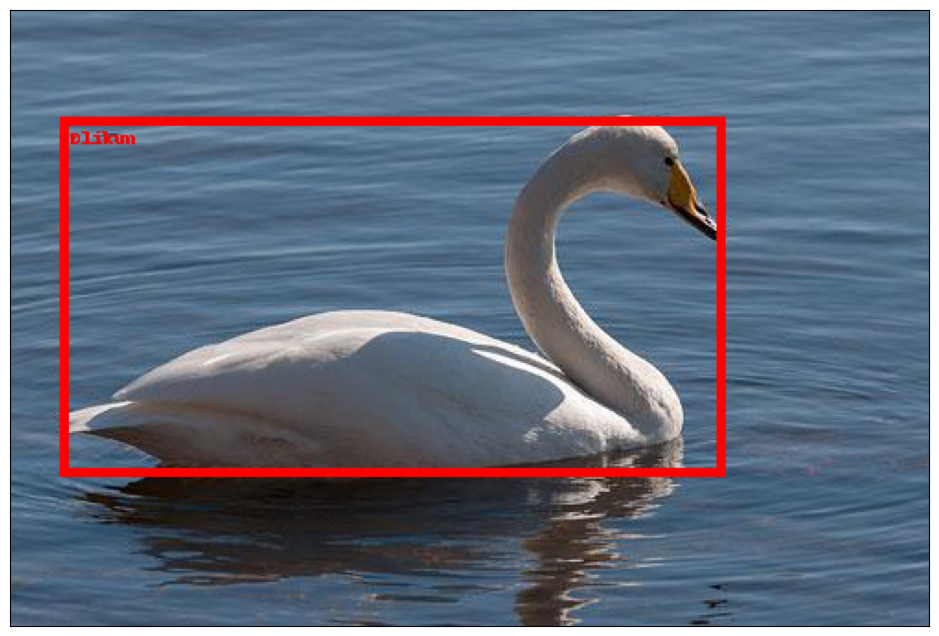

In [43]:
index = 10
train_detection_dataset.transform = None
draw_boxes_single_image(
    T.PILToTensor()(train_detection_dataset[index][0]),
    train_detection_dataset[index][1]['boxes'],
    [idx2target[label.item()] for label in train_detection_dataset[index][1]['labels']]
)

In [18]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_detection_model():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(train_detection_dataset.classes))
    
    return model

In [19]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.7 MB/s eta 0:00:00


In [20]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import batched_nms


def intersection_over_union(dt_bbox, gt_bbox):
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])

    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)


def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

@torch.inference_mode()
def visualize(model, batch):
    model.eval()
    
    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idx2target[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idx2target[label.item()] for label in prediction['labels']], width=5, colors='red')
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [21]:
def train(model):
    model.train()

    for x, y in tqdm(train_loader, desc='Train'):
        x = list(_.to(device).float() for _ in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        optimizer.zero_grad()

        output = model(x, y)
        
        loss_sum = sum(loss for loss in output.values())

        loss_sum.backward()

        optimizer.step()

In [22]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    
    metric = MeanAveragePrecision()

    for x, y in tqdm(loader, desc='Evaluation'):
        x = list(_.to(device).float() for _ in x)

        output = model(x)
        
        output = [{k: v.cpu() for k, v in t.items()} for t in output]

        metric.update(output, y)

    return metric.compute()['map']

In [23]:
def plot_stats(
    train_map,
    valid_map,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' mAP')
    
    plt.plot(train_map, label='Train mAP')
    plt.plot(valid_map, label='Valid mAP')
    plt.legend()
    plt.grid()

    plt.show()

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
train_detection_dataset.transform = T.PILToTensor()
test_detection_dataset.transform = T.PILToTensor()

In [26]:
train_loader = DataLoader(train_detection_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(test_detection_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(valid_loader))

    for epoch in range(num_epochs):
        train(model)

        clear_output()

        visualize(model, batch)

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [31]:
train_detection_dataset[0][1]

{'boxes': tensor([[ 94,  29, 232, 170]]), 'labels': tensor([0])}

In [29]:
model = get_detection_model().to(device)

optimizer = Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 170MB/s]


In [37]:
for x, y in tqdm(train_detection_dataset, total=len(train_detection_dataset)):
  if y["boxes"].size() == torch.Size([0]):
    x

  0%|          | 0/6777 [00:00<?, ?it/s]

In [30]:
whole_train_valid_cycle(model, 15, 'Faster-RCNN detection')

Train:   0%|          | 0/848 [00:00<?, ?it/s]

AssertionError: ignored